# 機器學習：紅酒品質分類

## 載入資料集

In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_wine

# 讀取紅酒品質資料集
data = load_wine()
# 轉成 DataFrame
df = pd.DataFrame(data.data, columns=data.feature_names)
# 新增品質欄位
df['quality'] = data.target
df

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,quality
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,2
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,2
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,2
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,2


## 前處理

In [2]:
# 分割資料集
X = df.drop('quality', axis=1)
y = df['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 建立模型

In [3]:
# 使用XGBoost進行訓練
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

## 預測結果

In [4]:
# 預測驗證集(沒訓練的資料)
y_pred = xgb.predict(X_test)

# 計算混淆矩陣、Recall、Precision
cm = confusion_matrix(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
accuracy = (cm[0][0] + cm[1][1] + cm[2][2]) / cm.sum()

print("Accuracy：", accuracy)
print("Recall：", recall)
print("Precision：", precision)


Accuracy： 0.9444444444444444
Recall： 0.9444444444444444
Precision： 0.9513888888888888


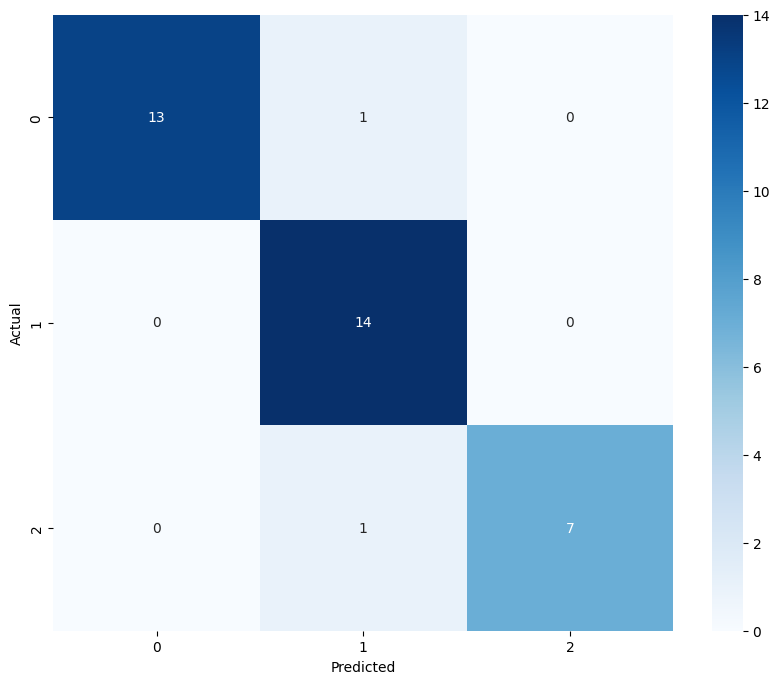

In [5]:
# 繪製混淆矩陣
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 補充：搜尋最佳參數

In [6]:
# 設定參數範圍
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'n_estimators': [50, 100, 200]
}

# 使用GridSearchCV進行交叉驗證和參數調整
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# 輸出最佳參數
print("最佳參數：", grid_search.best_params_)


最佳參數： {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


In [7]:
# 使用最佳參數重新訓練模型
best_xgb = grid_search.best_estimator_
best_xgb.fit(X_train, y_train)

# 預測測試集
y_pred_best = best_xgb.predict(X_test)

# 計算混淆矩陣、Recall、Precision
cm_best = confusion_matrix(y_test, y_pred_best)
recall_best = recall_score(y_test, y_pred_best, average='weighted')
precision_best = precision_score(y_test, y_pred_best, average='weighted')

print("最佳參數混淆矩陣：\n", cm_best)
print("最佳參數Recall：", recall_best)
print("最佳參數Precision：", precision_best)

最佳參數混淆矩陣：
 [[14  0  0]
 [ 0 14  0]
 [ 0  1  7]]
最佳參數Recall： 0.9722222222222222
最佳參數Precision： 0.974074074074074
